In [5]:
import opendatasets

opendatasets.download('https://www.kaggle.com/datasets/mohamedgamal07/reduced-mnist')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading reduced-mnist.zip to .\reduced-mnist


100%|██████████| 9.62M/9.62M [00:06<00:00, 1.47MB/s]


In [1]:
import numpy as np
import cv2
import os
import glob
from PIL import Image
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
train_path = 'H:/Jupyter_Notebooks/reduced-mnist/Reduced MNIST Data/Reduced Trainging data/'
test_path = 'H:/Jupyter_Notebooks/reduced-mnist/Reduced MNIST Data/Reduced Testing data/'


In [2]:
classes = os.listdir(test_path)
num_classes = len(classes)
source_path=[test_path +f'{a}' for a in classes]
classes_dir=[f'{a}_dir' for a in classes]
for cl_dir,cl_path in zip(classes_dir,source_path):
    print(cl_dir,': ',len(os.listdir(cl_path)))

0_dir :  200
1_dir :  200
2_dir :  200
3_dir :  200
4_dir :  200
5_dir :  200
6_dir :  200
7_dir :  200
8_dir :  200
9_dir :  200


In [3]:
def copy(data_path):
    imgs = []
    labels = []
    folders = os.listdir(data_path)
    for folder in folders:
        fullpath = os.path.join(data_path, folder)
        images = glob.glob(os.path.join(fullpath,'*.jpg'))
        for img in images:
            labels.append(img.split('/')[-1][0])
            img = cv2.imread(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            imgs.append(img)

    return np.array(imgs), np.array(labels)

In [87]:
X_train, y_train = copy(train_path)
X_train = X_train/255.0 
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = copy(test_path)
X_test = X_test/255.0
X_test, y_test = shuffle(X_test, y_test, random_state=42)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

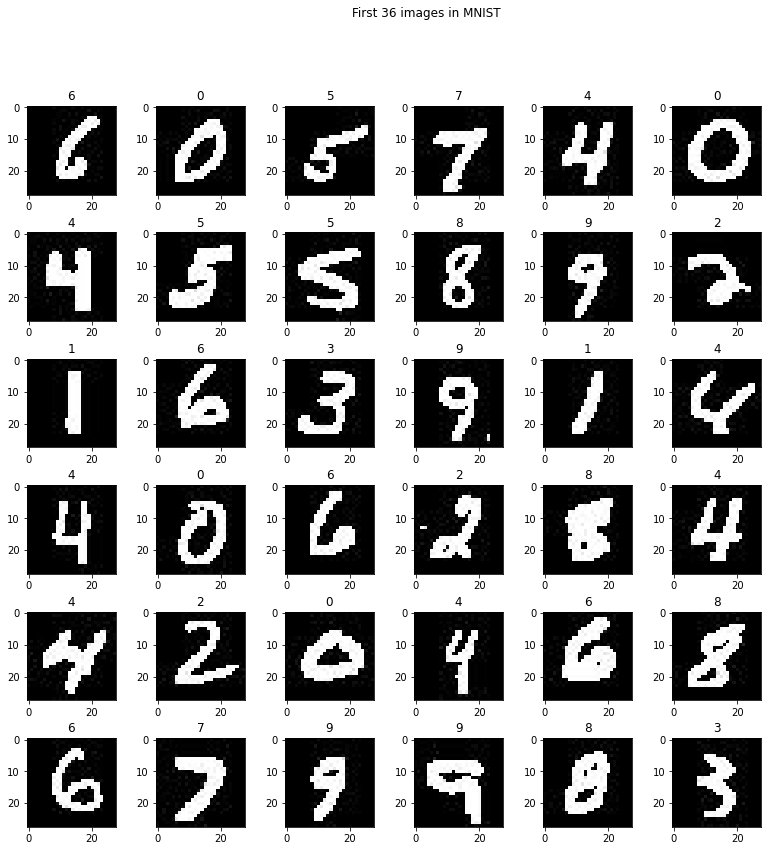

In [90]:
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
fig.suptitle('First 36 images in MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(X_train[x + y * 6].reshape((28, 28)), cmap = 'gray')
    ax[x, y].set_title(y_train[x + y * 6])

In [130]:
from sklearn.preprocessing import StandardScaler
from scipy.fftpack import dct
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import Functions as f
import time

def unroll(x):
    x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
    return x


def dct2(block):
    start = time.time()
    l = []
    for b in block:
        l.append(dct(dct(b.T, norm='ortho').T, norm='ortho'))
    end = time.time()
    return np.array(l), end-start

def small_zigzag(x):
    start = time.time()
    l = []
    for a in x:
        l.append(np.concatenate([np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0])])[0:200])
    end = time.time()
    return np.array(l), end-start

pca_n = 0.9
def pca(x_train, x_test, n):
    start = time.time()
    pca = PCA(n_components=n, random_state=42)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)
    end = time.time()
    print(f'time it took PCA:{end - start}, shape of X train: {x_train.shape}, x_test = {x_test.shape}' )
    return x_train, x_test

clusters = [1, 4, 16, 32]
def kmeans(x_train, n):
    start = time.time()
    KMS = KMeans(n_clusters=n, random_state=42)
    KMS.fit(x_train)
    end = time.time()
    return KMS, end - start
def retrieve_info_kmeans(cluster_labels, y_train, model):
    reference_labels = {}
    for i in range(len(np.unique(model.labels_))):
        index = np.where(model.labels_ == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels   

mixtures = [1, 2, 4]
def gmm(x_train, n):
    start = time.time()
    GMM = GaussianMixture(n_components=n, random_state=42)
    GMM.fit(x_train)
    end = time.time()
    return GMM, end - start

def retrieve_info_gmm(x, y_train, model):
    labels = model.predict(x)
    reference_labels = {}
    for i in range(len(np.unique(labels))):
        index = np.where(labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels, labels

kinds = ['linear', 'rbf']
def svm(x_train, x_test, kind):
    start = time.time()
    SVM = SVC(kernel=kind, random_state=42)
    SVM.fit(x_train, y_train)
    y_hat = SVM.predict(x_train)
    y_pred = SVM.predict(x_test)
    end = time.time()
    print(f'SVM kernel: {kind}, SVM score for train: {accuracy_score(y_train, y_hat)*100}%, SVM score for test: {accuracy_score(y_test, y_pred)*100}%, took: { end - start}')
    return y_hat, y_pred

In [93]:
X_tr_pca = unroll(X_train)
X_te_pca = unroll(X_test)
X_tr_pca, X_te_pca = pca(X_tr_pca, X_te_pca, pca_n)

time it took PCA:1.0498216152191162, shape of X train: (10000, 167), x_test = (2000, 167)


In [94]:
X_tr_dct, t1 = dct2(X_train)
X_tr_dct_zz, t2 = small_zigzag(X_tr_dct)
X_train
print('Generated Train DCT with Zig-Zag in {} seconds, shape of train{}'.format(t1+t2, X_tr_dct_zz.shape))
X_te_dct, t1 = dct2(X_test)
X_te_dct_zz, t2 = small_zigzag(X_te_dct)
print('Generated Test DCT with Zig-Zag in {} seconds, shape of test{}'.format((t1+t2), X_te_dct_zz.shape))

Generated Train DCT with Zig-Zag in 2.259641170501709 seconds, shape of train(10000, 200)
Generated Test DCT with Zig-Zag in 0.4289977550506592 seconds, shape of test(2000, 200)


In [98]:
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer='adam')
history = stacked_ae.fit(X_train, X_train, epochs=15,
                         validation_data=(X_test, X_test))

Epoch 1/15
313/313 [==============================] - 3s 7ms/step - loss: 0.2364 - val_loss: 0.1715
Epoch 2/15
313/313 [==============================] - 2s 6ms/step - loss: 0.1558 - val_loss: 0.1474
Epoch 3/15
313/313 [==============================] - 2s 5ms/step - loss: 0.1411 - val_loss: 0.1377
Epoch 4/15
313/313 [==============================] - 2s 5ms/step - loss: 0.1336 - val_loss: 0.1326
Epoch 5/15
313/313 [==============================] - 2s 5ms/step - loss: 0.1292 - val_loss: 0.1297
Epoch 6/15
313/313 [==============================] - 2s 5ms/step - loss: 0.1260 - val_loss: 0.1270
Epoch 7/15
313/313 [==============================] - 2s 6ms/step - loss: 0.1236 - val_loss: 0.1249
Epoch 8/15
313/313 [==============================] - 2s 6ms/step - loss: 0.1220 - val_loss: 0.1234
Epoch 9/15
313/313 [==============================] - 2s 6ms/step - loss: 0.1207 - val_loss: 0.1227
Epoch 10/15
313/313 [==============================] - 2s 5ms/step - loss: 0.1196 - val_loss: 0.1219

In [113]:
X_train_encoded = stacked_ae.predict(X_train)
X_train_encoded_unrolled = unroll(X_train_encoded)
X_test_encoded = stacked_ae.predict(X_test)
X_test_encoded_unrolled = unroll(X_test_encoded)

In [120]:
print(X_train_encoded_unrolled.shape, X_test_encoded_unrolled.shape)

(10000, 784) (2000, 784)


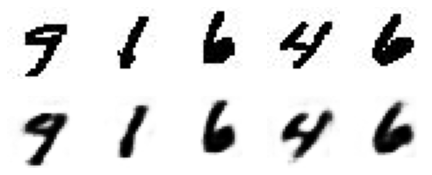

In [100]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)      

In [117]:
for cluster in clusters:
    #Train DCT
    print('For DCT Train')
    start = time.time()
    kmeans_dct, total_time  = kmeans(X_tr_dct_zz, cluster)
    reference_labels = retrieve_info_kmeans(kmeans_dct.labels_, y_train, kmeans_dct)
    number_labels = np.random.rand(len(kmeans_dct.labels_))
    for i in range(len(kmeans_dct.labels_)):
        number_labels[i] = reference_labels[kmeans_dct.labels_[i]]
    end = time.time()
    print(f'Mode DCT, KMeans with clusters: {cluster}, KMeans train score: {accuracy_score(number_labels, y_train)*100}%, took: {end - start + total_time}')
    #Test DCT
    print('For DCT Test')
    start = time.time()
    kmeans_dct, total_time  = kmeans(X_te_dct_zz, cluster)
    reference_labels = retrieve_info_kmeans(kmeans_dct.labels_, y_test, kmeans_dct)
    number_labels = np.random.rand(len(kmeans_dct.labels_))
    for i in range(len(kmeans_dct.labels_)):
        number_labels[i] = reference_labels[kmeans_dct.labels_[i]]
    end = time.time()
    print(f'Mode DCT, KMeans with clusters: {cluster}, KMeans test score: {accuracy_score(number_labels, y_test)*100}%, took: {end - start + total_time}')
    print('-'*50)
    #Train PCA
    print('For PCA Train')
    start = time.time()
    kmeans_pca, total_time  = kmeans(X_tr_pca, cluster)
    reference_labels = retrieve_info_kmeans(kmeans_pca.labels_, y_train, kmeans_pca)
    number_labels = np.random.rand(len(kmeans_pca.labels_))
    for i in range(len(kmeans_pca.labels_)):
        number_labels[i] = reference_labels[kmeans_pca.labels_[i]]
    end = time.time()
    print(f'Mode PCA, KMeans with clusters: {cluster}, KMeans train score: {accuracy_score(number_labels, y_train)*100}%, took: {end - start + total_time}')
    print('For PCA Test')
    start = time.time()
    kmeans_pca, total_time  = kmeans(X_te_pca, cluster)
    reference_labels = retrieve_info_kmeans(kmeans_pca.labels_, y_test, kmeans_pca)
    number_labels = np.random.rand(len(kmeans_pca.labels_))
    for i in range(len(kmeans_pca.labels_)):
        number_labels[i] = reference_labels[kmeans_pca.labels_[i]]
    end = time.time()
    print(f'Mode PCA, KMeans with clusters: {cluster}, KMeans test score: {accuracy_score(number_labels, y_test)*100}%, took: {end - start + total_time}')
    print('-'*50)
    print('For autoencoder Train')
    start = time.time()
    kmeans_ae, total_time  = kmeans(X_train_encoded_unrolled, cluster)
    reference_labels = retrieve_info_kmeans(kmeans_ae.labels_, y_train, kmeans_ae)
    number_labels = np.random.rand(len(kmeans_ae.labels_))
    for i in range(len(kmeans_ae.labels_)):
        number_labels[i] = reference_labels[kmeans_ae.labels_[i]]
    end = time.time()
    print(f'Mode AutoEncoder, KMeans with clusters: {cluster}, KMeans train score: {accuracy_score(number_labels, y_train)*100}%, took: {end - start + total_time}')
    print('For autoencoder Test')
    start = time.time()
    kmeans_ae, total_time  = kmeans(X_test_encoded_unrolled, cluster)
    reference_labels = retrieve_info_kmeans(kmeans_ae.labels_, y_test, kmeans_ae)
    number_labels = np.random.rand(len(kmeans_ae.labels_))
    for i in range(len(kmeans_ae.labels_)):
        number_labels[i] = reference_labels[kmeans_ae.labels_[i]]
    end = time.time()
    print(f'Mode AutoEncoder, KMeans with clusters: {cluster}, KMeans test score: {accuracy_score(number_labels, y_test)*100}%, took: {end - start + total_time}')
    print('-'*100)

For DCT Train
Mode DCT, KMeans with clusters: 1, KMeans train score: 10.0%, took: 2.7774579524993896
For DCT Test
Mode DCT, KMeans with clusters: 1, KMeans test score: 10.0%, took: 2.556004762649536
--------------------------------------------------
For PCA Train
Mode PCA, KMeans with clusters: 1, KMeans train score: 10.0%, took: 2.703112840652466
For PCA Test
Mode PCA, KMeans with clusters: 1, KMeans test score: 10.0%, took: 2.5119998455047607
--------------------------------------------------
For autoencoder Train
Mode AutoEncoder, KMeans with clusters: 1, KMeans train score: 10.0%, took: 3.64438533782959
For autoencoder Test
Mode AutoEncoder, KMeans with clusters: 1, KMeans test score: 10.0%, took: 2.736999273300171
----------------------------------------------------------------------------------------------------
For DCT Train
Mode DCT, KMeans with clusters: 4, KMeans train score: 36.52%, took: 1.630054235458374
For DCT Test
Mode DCT, KMeans with clusters: 4, KMeans test score: 38

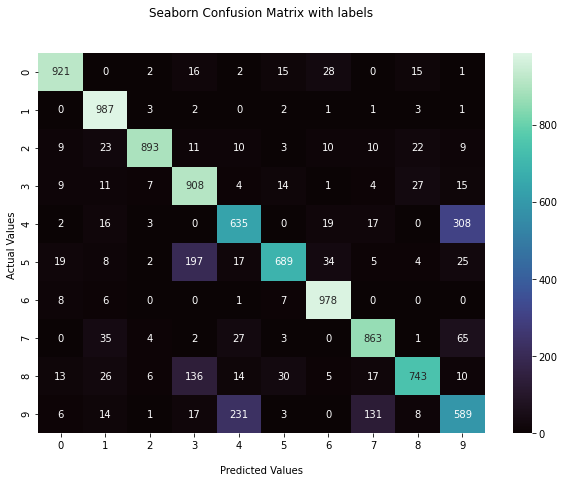

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

kmeans_pca, total_time  = kmeans(X_tr_pca, 32)
reference_labels = retrieve_info_kmeans(kmeans_pca.labels_, y_train, kmeans_pca)
number_labels = np.random.rand(len(kmeans_pca.labels_))
for i in range(len(kmeans_pca.labels_)):
    number_labels[i] = reference_labels[kmeans_pca.labels_[i]]
    
cf_matrix = confusion_matrix(y_train, number_labels)

plt.figure(figsize = (10,7))
ax = sns.heatmap(cf_matrix, annot=True, cmap='mako',  fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

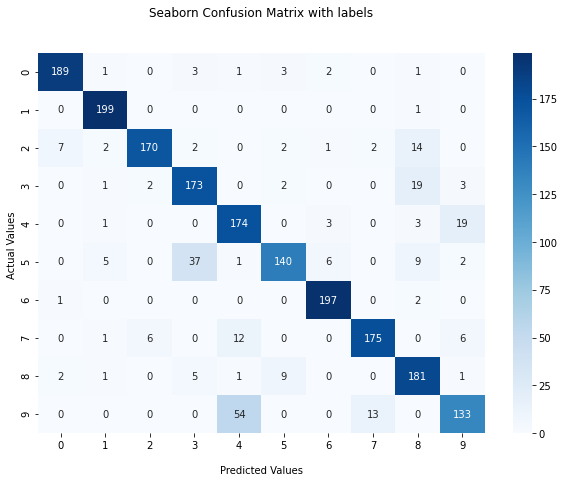

In [126]:
kmeans_pca, total_time  = kmeans(X_te_pca, 32)
reference_labels = retrieve_info_kmeans(kmeans_pca.labels_, y_test, kmeans_pca)
number_labels = np.random.rand(len(kmeans_pca.labels_))
for i in range(len(kmeans_pca.labels_)):
    number_labels[i] = reference_labels[kmeans_pca.labels_[i]]

cf_matrix = confusion_matrix(y_test, number_labels)

plt.figure(figsize = (10,7))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',  fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

In [118]:
for mix in mixtures:
    #Train
    print('For DCT Train')
    start = time.time()
    GMM_DCT, total_time  = gmm(X_tr_dct_zz, mix)
    reference_labels, labels = retrieve_info_gmm(X_tr_dct_zz, y_train, GMM_DCT)
    number_labels = np.random.rand(len(labels))
    for i in range(len(labels)):
        number_labels[i] = reference_labels[labels[i]]
    end = time.time()
    print(f'Gaussian Mixture with mixture: {mix}, Gaussian Mixture train score : {accuracy_score(number_labels,y_train)*100}%, took: {end - start + total_time}')
    #Test
    print('For DCT Test')
    start = time.time()
    GMM_DCT, total_time  = gmm(X_te_dct_zz, mix)
    reference_labels, labels = retrieve_info_gmm(X_te_dct_zz, y_test, GMM_DCT)
    number_labels = np.random.rand(len(labels))
    for i in range(len(labels)):
        number_labels[i] = reference_labels[labels[i]]
    end = time.time()
    print(f'Gaussian Mixture with mixture: {mix}, Gaussian Mixture test score : {accuracy_score(number_labels,y_test)*100}%, took: {end - start + total_time}')
    print('-'*50)
    #Train
    print('For PCA Train')
    start = time.time()
    GMM_pca, total_time  = gmm(X_tr_pca, mix)
    reference_labels, labels = retrieve_info_gmm(X_tr_pca, y_train, GMM_pca)
    number_labels = np.random.rand(len(labels))
    for i in range(len(labels)):
        number_labels[i] = reference_labels[labels[i]]
    end = time.time()
    print(f'Gaussian Mixture with mixture: {mix}, Gaussian Mixture score : {accuracy_score(number_labels,y_train)*100}%, took: {end - start + total_time}')
    #Test
    print('For PCA Test')
    start = time.time()
    GMM_pca, total_time  = gmm(X_te_pca, mix)
    reference_labels, labels = retrieve_info_gmm(X_te_pca, y_test, GMM_pca)
    number_labels = np.random.rand(len(labels))
    for i in range(len(labels)):
        number_labels[i] = reference_labels[labels[i]]
    end = time.time()
    print(f'Gaussian Mixture with mixture: {mix}, Gaussian Mixture test score : {accuracy_score(number_labels,y_test)*100}%, took: {end - start + total_time}')
    print('-'*50)
    #AutoEncoder Train
    print('For AutoEncode Train')
    start = time.time()
    GMM_ae, total_time  = gmm(X_train_encoded_unrolled, mix)
    reference_labels, labels = retrieve_info_gmm(X_train_encoded_unrolled, y_train, GMM_ae)
    number_labels = np.random.rand(len(labels))
    for i in range(len(labels)):
        number_labels[i] = reference_labels[labels[i]]
    end = time.time()
    print(f'Gaussian Mixture with mixture: {mix}, Gaussian Mixture score : {accuracy_score(number_labels,y_train)*100}%, took: {end - start + total_time}')
    #Test
    print('For AutoEncode Test')
    start = time.time()
    GMM_ae, total_time  = gmm(X_test_encoded_unrolled, mix)
    reference_labels, labels = retrieve_info_gmm(X_test_encoded_unrolled, y_test, GMM_ae)
    number_labels = np.random.rand(len(labels))
    for i in range(len(labels)):
        number_labels[i] = reference_labels[labels[i]]
    end = time.time()
    print(f'Gaussian Mixture with mixture: {mix}, Gaussian Mixture test score : {accuracy_score(number_labels,y_test)*100}%, took: {end - start + total_time}')
    print('-'*10)

For DCT Train
Gaussian Mixture with mixture: 1, Gaussian Mixture train score : 10.0%, took: 0.9746582508087158
For DCT Test
Gaussian Mixture with mixture: 1, Gaussian Mixture test score : 10.0%, took: 0.7059974670410156
--------------------------------------------------
For PCA Train
Gaussian Mixture with mixture: 1, Gaussian Mixture score : 10.0%, took: 1.0779922008514404
For PCA Test
Gaussian Mixture with mixture: 1, Gaussian Mixture test score : 10.0%, took: 0.4490058422088623
--------------------------------------------------
For AutoEncode Train
Gaussian Mixture with mixture: 1, Gaussian Mixture score : 10.0%, took: 4.706999063491821
For AutoEncode Test
Gaussian Mixture with mixture: 1, Gaussian Mixture test score : 10.0%, took: 1.2409884929656982
----------
For DCT Train
Gaussian Mixture with mixture: 2, Gaussian Mixture train score : 19.16%, took: 9.217040777206421
For DCT Test
Gaussian Mixture with mixture: 2, Gaussian Mixture test score : 19.8%, took: 1.0210092067718506
------

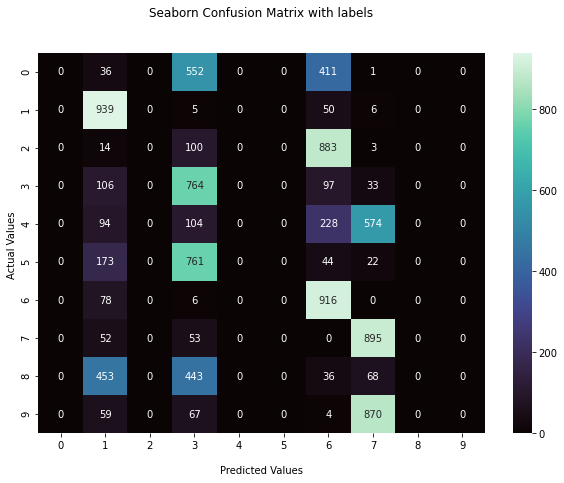

In [128]:
GMM_pca, total_time  = gmm(X_tr_pca, 4)
reference_labels, labels = retrieve_info_gmm(X_tr_pca, y_train, GMM_pca)
number_labels = np.random.rand(len(labels))
for i in range(len(labels)):
    number_labels[i] = reference_labels[labels[i]]

cf_matrix = confusion_matrix(y_train, number_labels)

plt.figure(figsize = (10,7))
ax = sns.heatmap(cf_matrix, annot=True, cmap='mako',  fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

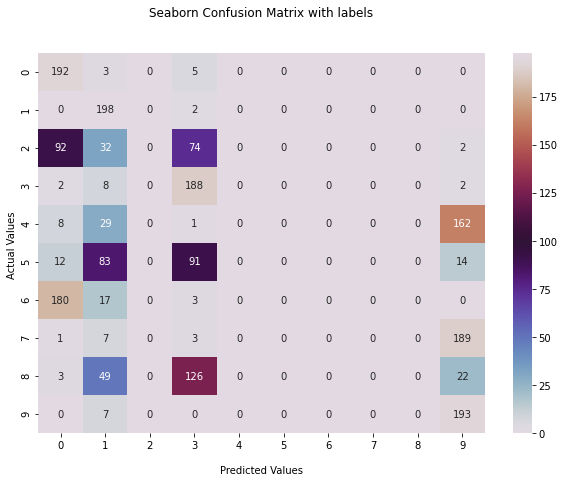

In [129]:
GMM_pca, total_time  = gmm(X_te_pca, mix)
reference_labels, labels = retrieve_info_gmm(X_te_pca, y_test, GMM_pca)
number_labels = np.random.rand(len(labels))
for i in range(len(labels)):
    number_labels[i] = reference_labels[labels[i]]

cf_matrix = confusion_matrix(y_test, number_labels)

plt.figure(figsize = (10,7))
ax = sns.heatmap(cf_matrix, annot=True, cmap='twilight',  fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

In [119]:
for kind in kinds:
    print('For DCT')
    svm(X_tr_dct_zz, X_te_dct_zz, kind)
    print('*'*50)
    print('For PCA')
    svm(X_tr_pca, X_te_pca, kind)
    print('*'*50)
    print('For AutoEncoder')
    svm(X_train_encoded_unrolled, X_test_encoded_unrolled, kind)
    print('*'*50)

For DCT
SVM kernel: linear, SVM score for train: 98.07000000000001%, SVM score for test: 94.35%, took: 9.264769792556763
**************************************************
For PCA
SVM kernel: linear, SVM score for train: 98.8%, SVM score for test: 93.8%, took: 5.716500520706177
**************************************************
For AutoEncoder
SVM kernel: linear, SVM score for train: 99.03999999999999%, SVM score for test: 94.69999999999999%, took: 22.00305438041687
**************************************************
For DCT
SVM kernel: rbf, SVM score for train: 97.66%, SVM score for test: 97.35000000000001%, took: 17.315446853637695
**************************************************
For PCA
SVM kernel: rbf, SVM score for train: 99.19%, SVM score for test: 97.7%, took: 21.125736236572266
**************************************************
For AutoEncoder
SVM kernel: rbf, SVM score for train: 97.09%, SVM score for test: 96.35000000000001%, took: 49.86711025238037
*************************

SVM kernel: linear, SVM score for train: 98.8%, SVM score for test: 93.8%, took: 6.102942228317261


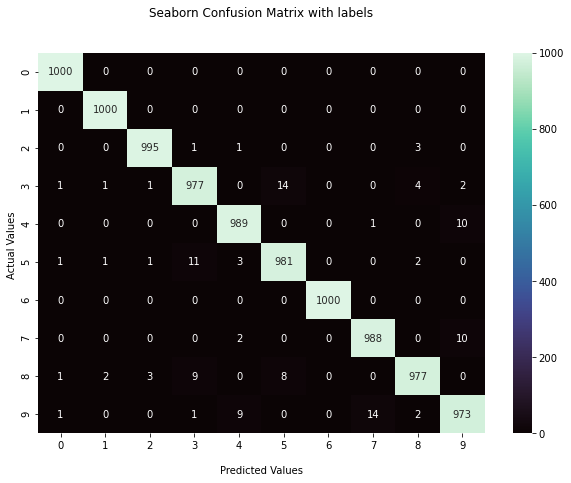

In [133]:
y_hat, y_pred = svm(X_tr_pca, X_te_pca, 'linear')

cf_matrix = confusion_matrix(y_train, y_hat)

plt.figure(figsize = (10,7))
ax = sns.heatmap(cf_matrix, annot=True, cmap='mako',  fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

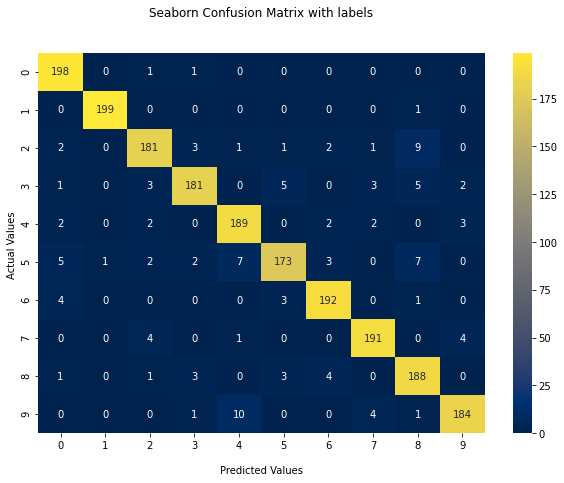

In [135]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (10,7))
ax = sns.heatmap(cf_matrix, annot=True, cmap='cividis',  fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()